In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc,accuracy_score,f1_score,precision_score,recall_score
import itertools
import joblib
from utilities import *


In [2]:
df = pd.read_csv('Clean_Data/train_values.csv'); df.head()
y_labels = pd.read_csv('Clean_Data/train_labels.csv')

In [3]:
# we check the shape of our data
columns = df.columns
df.shape, y_labels.shape

((609674, 42), (609674, 1))

In [4]:
"""
I will be dropping some of the columns as they are not necessary for the investigation
"""
df = df.drop(['building_id', 'height_ft_post_eq', 'count_floors_post_eq'], axis=1)
df.shape

(609674, 39)

In [5]:
"""
We will change the damage grade values into categorical strings for better visualisation
"""
df.damage_grade[df.damage_grade == 1] = 'low'
df.damage_grade[df.damage_grade == 2] = 'medium'
df.damage_grade[df.damage_grade == 3] = 'high'

/Users/flatiron/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


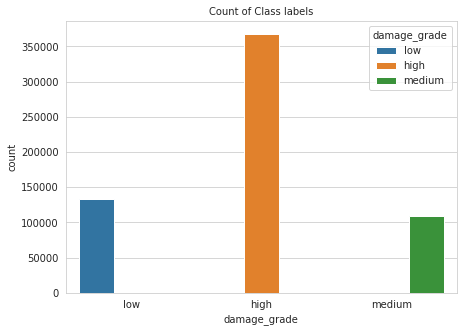

In [6]:
"""
We will check if the data is balanced
"""

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(7,5))
plt.title('Count of Class labels', fontsize=10)
sns.countplot(x='damage_grade',data=df,hue='damage_grade')
plt.show()

In [7]:
print('Number of properties with low damage:{0:.2f}%'.format((len(df[df['damage_grade']=='low'])/len(df))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(df[df['damage_grade']=='medium'])/len(df))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(df[df['damage_grade']=='high'])/len(df))*100))

Number of properties with low damage:21.79%
Number of properties with medium damage:17.90%
Number of properties with high damage:60.31%


We can see that the data is not balanced and there are more cases of high damage labels. This means that when we carry out our machine learning model we will need to balance the dataset accordingly.

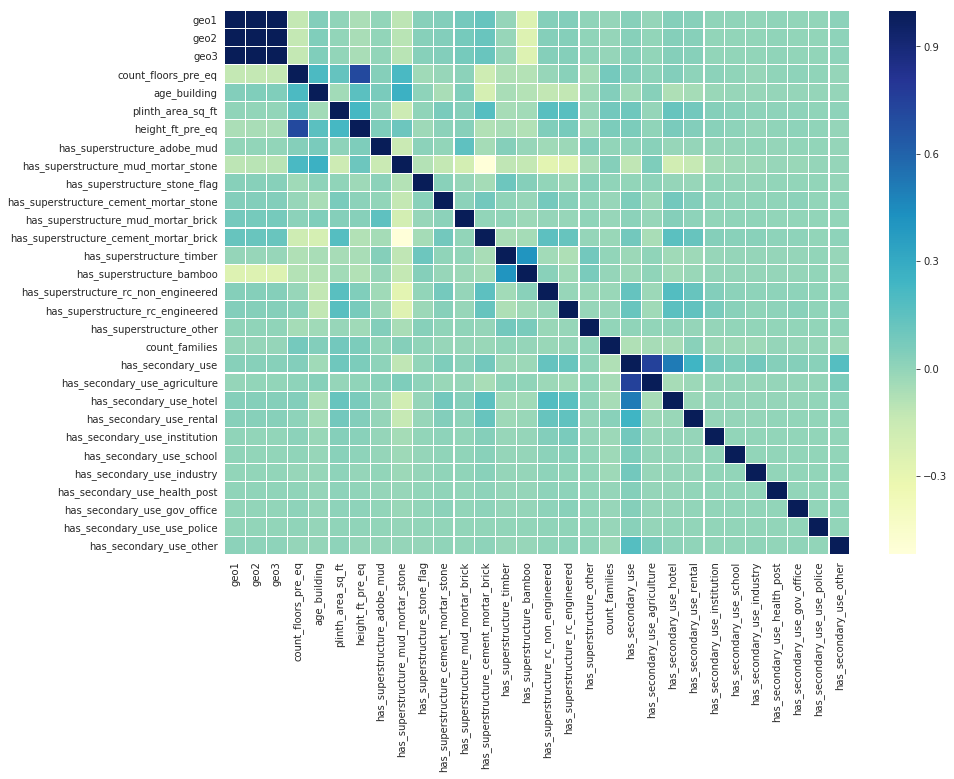

In [8]:
corrmat=df.corr(method='spearman')
f,ax=plt.subplots(figsize=(14,10))
sns.heatmap(corrmat,ax=ax,cmap="YlGnBu", linewidths=0.1)

We will first carry out a baseline model and then a randomforest model and then basis of our first model we will carry out further EDA.

In [9]:
"""
We need to make sure that there are no strings in our dataframe so we will turn them into categorical columns
"""
turn_cat(df)


In [10]:
cat_col # just to find out which columns were categorical

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'damage_grade',
 'legal_ownership_status']

In [13]:
# before we run our models we need to ensure that the labels are properly encoded

le = preprocessing.LabelEncoder()
for i in cat_col:
    df[i] = le.fit_transform(df[i])

In [13]:
# we will prepare our data for our models
np.random.seed(2)
df_train = pd.concat([df,y_labels], axis=1)

In [14]:
df_train = df_train.sample(100000);df_train.shape

(100000, 40)

In [15]:
X = df_train.drop(['damage_grade', 'Labels'], axis=1)
y = df_train['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 38), (20000, 38), (80000,), (20000,))

In [27]:
# we need to set our labels for our output results

labels=['Low','Medium','High']

### Baseline model:

we will build our first baseline by randomly predicting the labels and then carrying out logistic regression to check our score

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('clf', LogisticRegression(random_state=123, class_weight='balanced'))])

# Fit the pipelines
pipe_lr.fit(X_train, y_train)

print(pipe_lr.score(X_test, y_test))

0.49275


Our baseline score is 0.61 so we need to make sure that we can build a model that is better than 0.61. We will start with trying to improve our logistic regressor with the help of smote and scaling our features and then see how it improves the performance of our model.

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [23]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

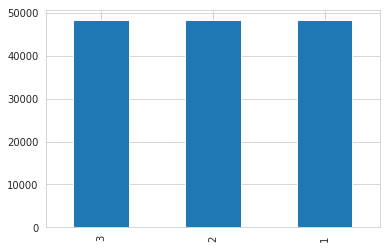

In [24]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [25]:
parameters = {'C':[0.01, 0.1, 1,5, 10], 'penalty':['l2','l1']}
log_reg = LogisticRegression(class_weight='balanced')
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid.fit(X_train_new, y_train_new)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.1s finished
/Users/flatiron/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 5, 10], 'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

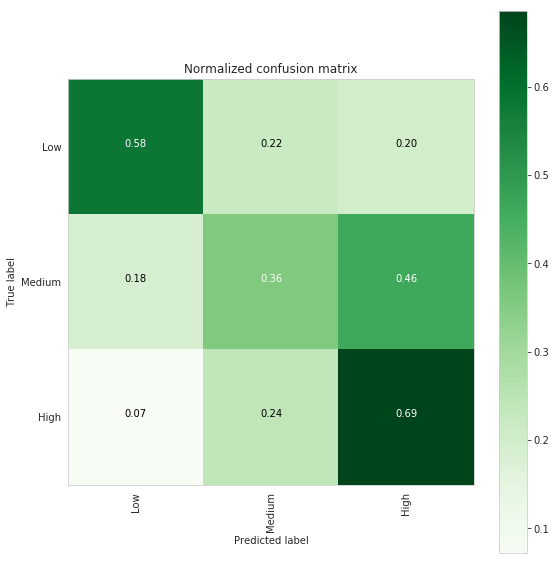

accuracy score for our model is 0.6049
precision score for our model is 0.6432
recall score for our model is 0.6049
f1 score for our model is 0.6208

-------------------------------------

Classification report is as follows: 
              precision    recall  f1-score   support

           1       0.62      0.58      0.60      4318
           2       0.25      0.36      0.29      3598
           3       0.77      0.69      0.72     12084

    accuracy                           0.60     20000
   macro avg       0.55      0.54      0.54     20000
weighted avg       0.64      0.60      0.62     20000



In [28]:
log_pred = log_reg_grid.predict(X_test)
print_class(log_reg_grid, log_pred)

In [29]:
joblib.dump(log_reg,'log_reg.pkl')

['log_reg.pkl']

## Random forest classifier

In [31]:
params = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True, stratify = y)

#params = {'max_depth':[2,3,5,7],'n_estimators':[20,50,100,200]}
rf=RandomForestClassifier(class_weight='balanced')
grid=GridSearchCV(rf,param_grid=params,n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 35.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                          

In [36]:
print(f"Training Accuracy: {grid.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {grid.best_params_}")

Training Accuracy: 70.79%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 150}


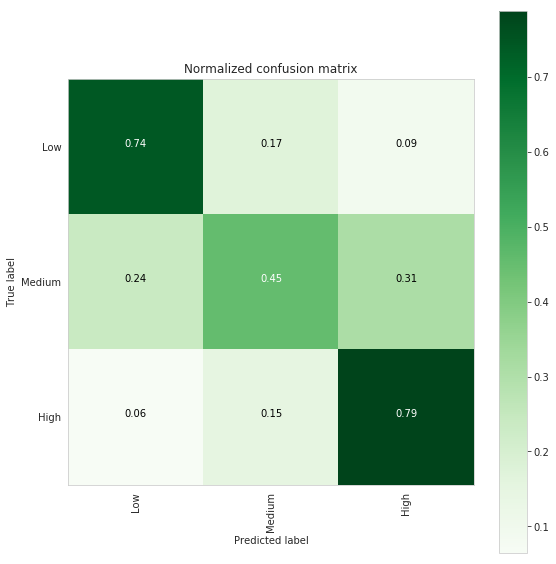

accuracy score for our model is 0.7183
precision score for our model is 0.7367
recall score for our model is 0.7183
f1 score for our model is 0.7256

-------------------------------------

Classification report is as follows: 
              precision    recall  f1-score   support

           1       0.67      0.74      0.70      4364
           2       0.39      0.45      0.42      3575
           3       0.86      0.79      0.82     12061

    accuracy                           0.72     20000
   macro avg       0.64      0.66      0.65     20000
weighted avg       0.74      0.72      0.73     20000



In [37]:
"""
uncomment rf if running this second time
"""

# rf = joblib.load('rf_first.pkl')
rf_pred = grid.predict(X_test)
print_class(grid, rf_pred)

In [38]:
joblib.dump(rf, 'rf_first.pkl')

['rf_first.pkl']

In [39]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [40]:
important_featurtes = rf_feat_importance(grid.best_estimator_, X_train)
important_featurtes.head(10)

,cols,imp
2,geo3,0.180919
1,geo2,0.125488
4,age_building,0.094543
5,plinth_area_sq_ft,0.093610
0,geo1,0.066716
6,height_ft_pre_eq,0.065707
15,has_superstructure_mud_mortar_stone,0.063439
10,ground_floor_type,0.042631
11,other_floor_type,0.040963
8,foundation_type,0.040181


## Multiclass with custom metrics

In [56]:
X = df_train.drop(['damage_grade', 'Labels'], axis=1)
y = df_train['Labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True, stratify = y)

In [57]:
df_train['damage_grade'].head()

496836    0
386954    0
237028    2
28020     2
510240    1
Name: damage_grade, dtype: int64

In [58]:
df_train['Labels'].head()

496836    2
386954    2
237028    1
28020     1
510240    0
Name: Labels, dtype: int64

In [69]:
train_data_lgbm = lgbm.Dataset(X_train, label=y_train)
test_data_lgbm = lgbm.Dataset(X_test, label=y_test)

learning_rate = 0.005
num_leaves = 20
feature_fraction = 0.6

params = {"objective": "multiclass",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "task": 'train',
          "drop_rate": 0.1,
          "is_unbalanced": True,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9,
          'num_class': 3
          }

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[test_data_lgbm],
                       valid_names=['val'],
                       num_boost_round=15000,
                       feval=lgb_f1_score,
                       verbose_eval=500,
                       early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds
[500]	val's multi_logloss: 0.691577	val's f1: 0.641996
[1000]	val's multi_logloss: 0.666737	val's f1: 0.651187
[1500]	val's multi_logloss: 0.657338	val's f1: 0.658807
[2000]	val's multi_logloss: 0.651389	val's f1: 0.664474
[2500]	val's multi_logloss: 0.646933	val's f1: 0.667935
[3000]	val's multi_logloss: 0.643528	val's f1: 0.672419
[3500]	val's multi_logloss: 0.640627	val's f1: 0.676179
[4000]	val's multi_logloss: 0.637973	val's f1: 0.680068
[4500]	val's multi_logloss: 0.635993	val's f1: 0.683757
[5000]	val's multi_logloss: 0.634262	val's f1: 0.685943
[5500]	val's multi_logloss: 0.63275	val's f1: 0.688151
[6000]	val's multi_logloss: 0.631402	val's f1: 0.689954
[6500]	val's multi_logloss: 0.630045	val's f1: 0.691126
[7000]	val's multi_logloss: 0.628803	val's f1: 0.692394
[7500]	val's multi_logloss: 0.627804	val's f1: 0.694053
[8000]	val's multi_logloss: 0.626732	val's f1: 0.694998
[8500]	val's multi_logloss: 0.625714	val's f

In [73]:
clf = joblib.load('gbm_third.pkl')

In [74]:
lgb_prediction = clf.predict(X_test)
lgb_prediction = lgb_prediction.argmax(axis = 1)

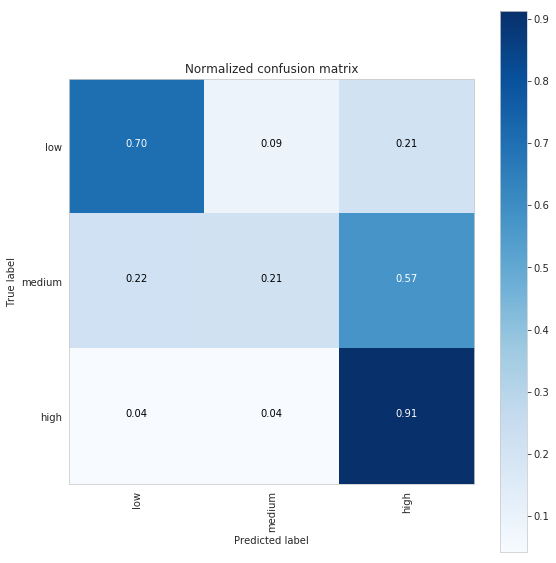

In [75]:
labels = ['low', 'medium', 'high']
plt.figure(figsize=(8,8))
plt.grid(b=False)
cm = confusion_matrix(y_test, lgb_prediction)
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')

In [76]:
report = classification_report(y_test, lgb_prediction);
print(report)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      4364
           1       0.46      0.21      0.29      3575
           2       0.79      0.91      0.85     12061

    accuracy                           0.74     20000
   macro avg       0.65      0.61      0.61     20000
weighted avg       0.71      0.74      0.72     20000

